# Импорт библиотек

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.stats.stattools import jarque_bera 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neural_network import MLPRegressor
#from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.arima_model import ARIMA

# Загрузка xls файлов + графики

In [21]:
filename_1 = 'Морожка1.xlsx'
df_1 = pd.read_excel(filename_1)
df_1.head()

,Дата,Продажи
0,2019-06-01,226
1,2019-06-02,173
2,2019-06-03,620
3,2019-06-04,646
4,2019-06-05,717


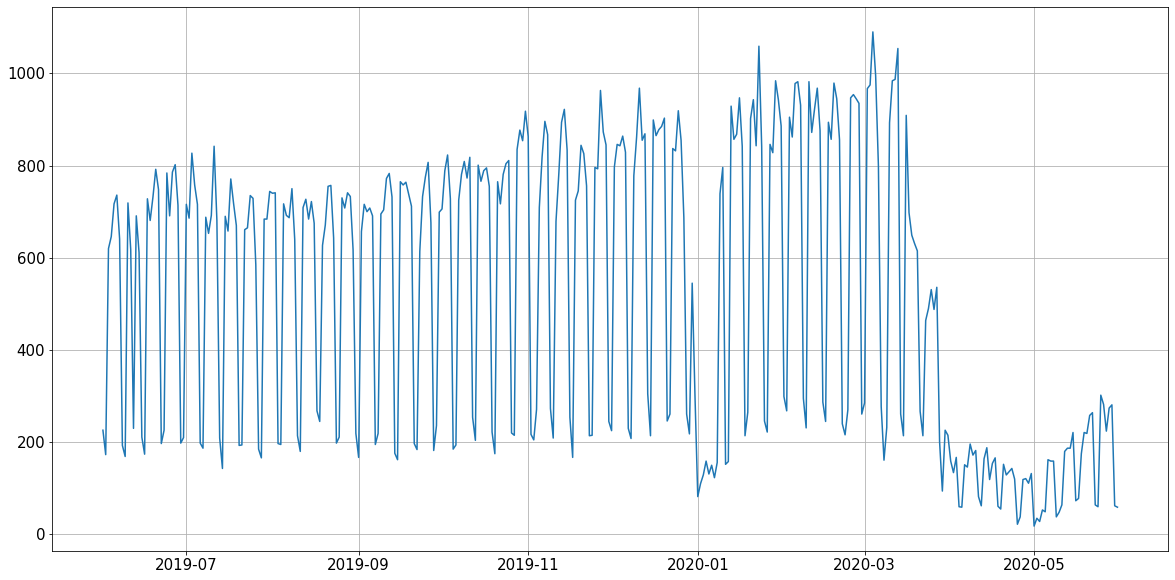

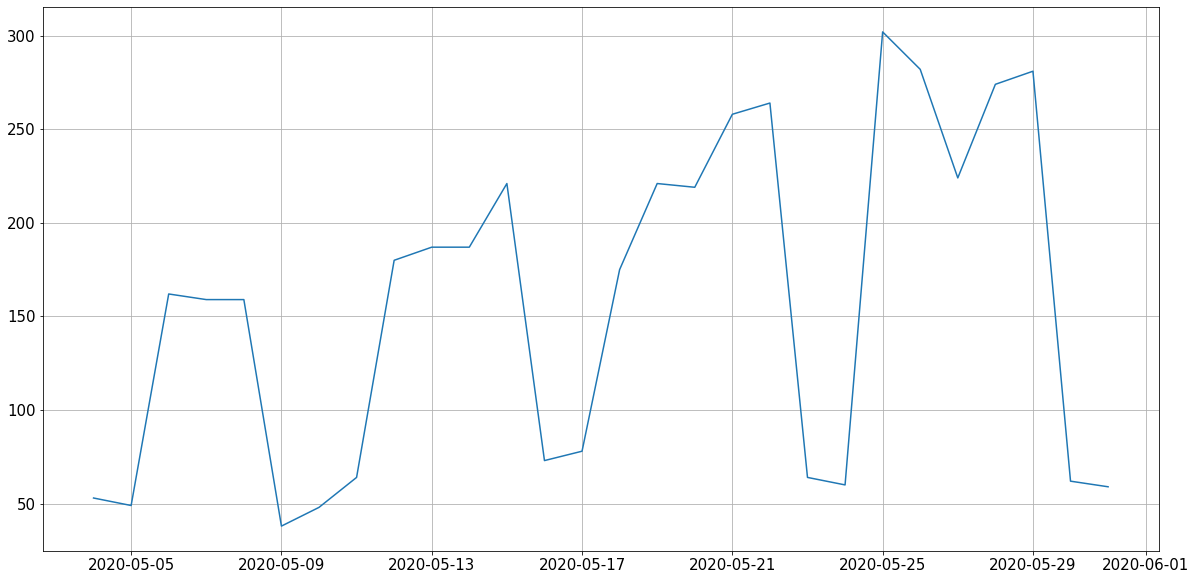

In [22]:
filename_1 = 'Морожка1.xlsx'
df_1 = pd.read_excel(filename_1)
df_1['Дата'] = pd.to_datetime(df_1.Дата)
df_1.set_index('Дата', inplace=True)

filename_w1 = 'Морожка недели1.xlsx'
df_w1 = pd.read_excel(filename_w1)
df_w1['Дата'] = pd.to_datetime(df_w1.Дата)
df_w1.set_index('Дата', inplace=True)

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 15})
plt.figure()
plt.plot(df_1.Продажи)
plt.grid()
plt.show()

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 15}) 
plt.figure()
plt.plot(df_w1.Продажи)
plt.grid()
plt.show()

# Берем первые разности и строим графики

In [23]:
first_diffs = df_1.Продажи.values[1:] - df_1.Продажи.values[:-1]
first_diffs = np.concatenate([first_diffs, [0]])
df_11 = df_1
df_11['Разности_1'] = first_diffs


In [24]:
df_11.head()

,Продажи,Разности_1
Дата,,
2019-06-01,226,-53
2019-06-02,173,447
2019-06-03,620,26
2019-06-04,646,71
2019-06-05,717,19


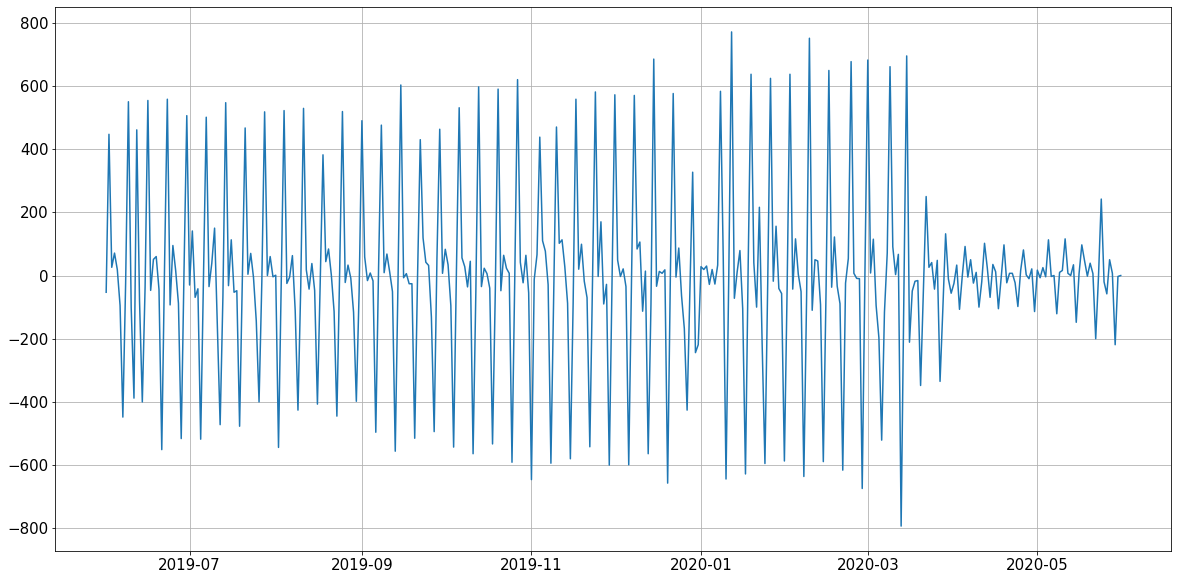

In [25]:
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 15}) 
plt.figure()
plt.plot(df_11.Разности_1)
plt.grid()
plt.show()

# ACF

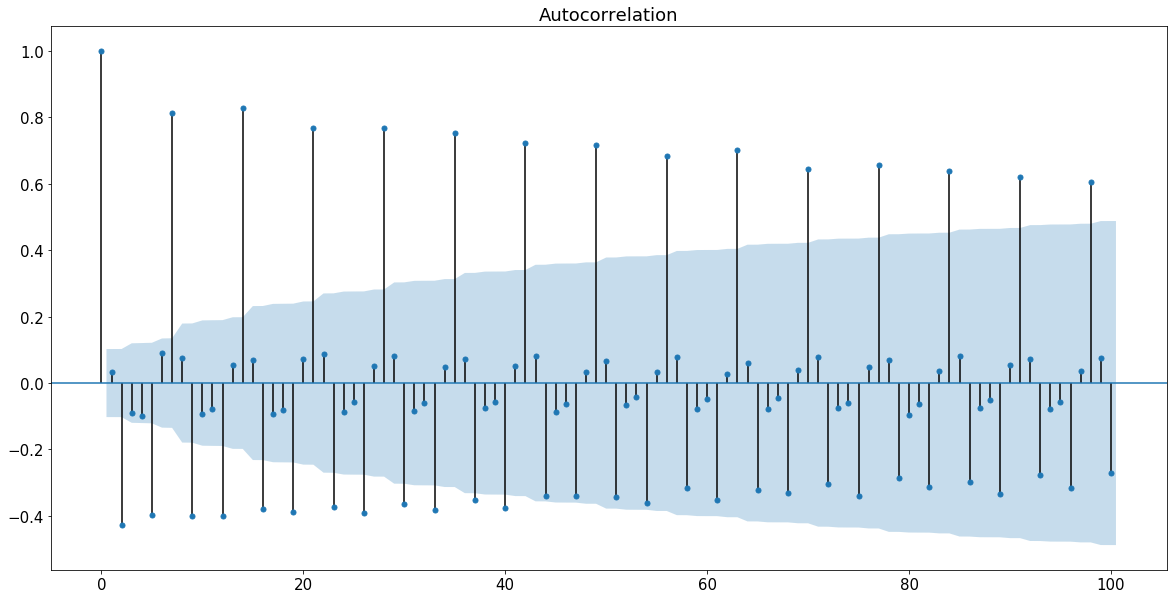

In [26]:
acf_plot = plot_acf(df_11.Разности_1, lags=100)

# PACF

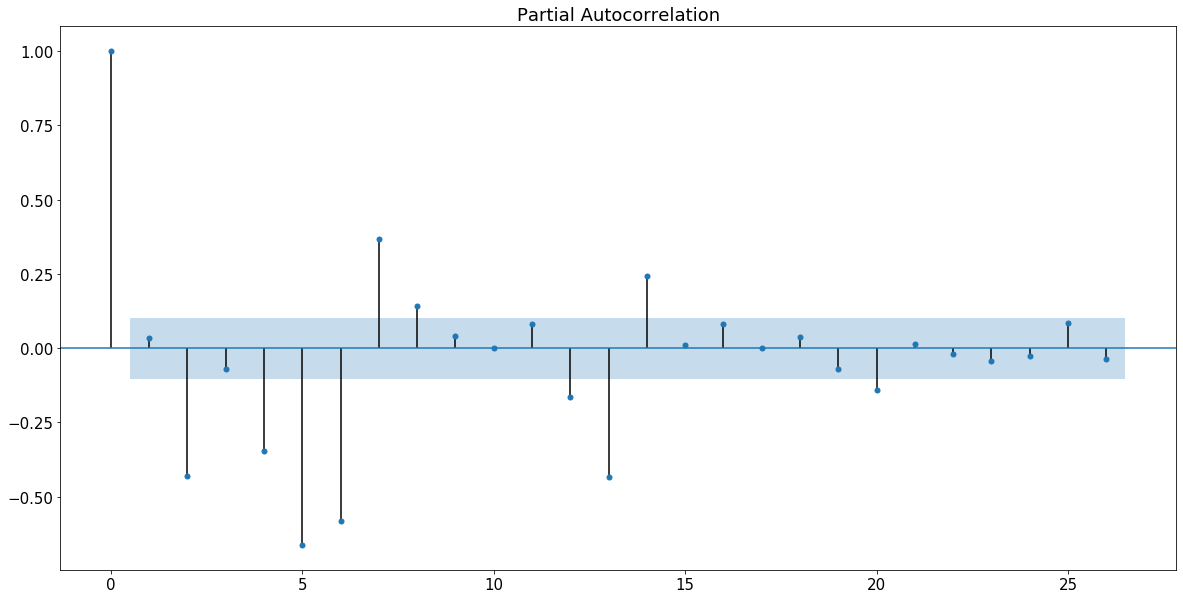

In [27]:
pacf_plot = plot_pacf(df_11.Разности_1)

# Извлечение признаков

In [28]:
filename_1 = 'Морожка1.xlsx'
df_1 = pd.read_excel(filename_1)
df_1['month_num'] = df_1['Дата'].apply(lambda x: x.date().month)
df_1['week_num'] = df_1['Дата'].apply(lambda x: x.week)
df_1['month_day'] = df_1['Дата'].apply(lambda x: x.day)
df_1['week_day'] = df_1['Дата'].apply(lambda x: x.date().weekday())

df_1['7_day_ago'] = df_1.Продажи
df_1['7_day_ago'] = df_1['7_day_ago'].shift(periods=7, fill_value=0)
df_1['14_day_ago'] = df_1.Продажи
df_1['14_day_ago'] = df_1['14_day_ago'].shift(periods=14, fill_value=0)
df_1['366_day_ago'] = df_1.Продажи
df_1['366_day_ago'] = df_1['366_day_ago'].shift(periods=366, fill_value=0)

df_1.tail()

,Дата,Продажи,month_num,week_num,month_day,week_day,7_day_ago,14_day_ago,366_day_ago
361,2020-05-27,224,5,22,27,2,219,187,0
362,2020-05-28,274,5,22,28,3,258,187,0
363,2020-05-29,281,5,22,29,4,264,221,0
364,2020-05-30,62,5,22,30,5,64,73,0
365,2020-05-31,59,5,22,31,6,60,78,0


# Разбиение на обучающую и тестовую выборки

In [29]:
test = 7
K = 0
N = len(df_1)
M = N-test
features = ['week_num',	'month_num', 'month_day', 'week_day', '7_day_ago', '14_day_ago', '366_day_ago']

X_train = df_1[features][K:M].values
y_train = df_1['Продажи'][K:M].values

X_test = df_1[features][M:N].values
y_test = df_1['Продажи'][M:N].values
print (M)

359


In [30]:
#mlpr = MLPRegressor(hidden_layer_sizes=(100, 60), max_iter=400)     #нейроннная сеть (2 скрытых слоя, 100 и 60 нейронов)
#mlpr.fit(X_train, y_train)

#xgbr = XGBRegressor(n_estimators=200, learning_rate=0.02, objective='reg:squarederror')     #xgboost
#xgbr.fit(X_train, y_train)

gbr = GradientBoostingRegressor(n_estimators=350)     #градиентный бустинг
gbr.fit(X_train, y_train)

knr = KNeighborsRegressor(n_neighbors=6)     #метод ближайших соседей
knr.fit(X_train, y_train)

history = [x for x in y_train]     #ARIMA (не использует признаки)
arima_predictions = list()
for t in range(N-M):
        model = ARIMA(history, order=(8,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        arima_predictions.append(yhat)
        obs = y_test[t]
        history.append(obs)
arima_predict = []
for i in range(N-M):
  arima_predict.append(arima_predictions[i][0])

# Таблица важности каждой feature (не обязательно, просто для наглядности)

Таблица важности каждой feature (не обязательно, просто для наглядности) {form-width: "40%"}

In [31]:
k=0
description = ['Номер недели', 'Номер месяца', 'Номер дня в месяце','День недели', 'Продажи в этот день неделю назад', 'Продажи в этот день 2 недели назад', 'Продажи в этот день год назад']
feature_importances = pd.DataFrame(columns=['Имя', 'Значение', 'Описание'])
for i in gbr.feature_importances_:
        feature_importance = {}
        feature_importance['Имя'] = features[k]
        feature_importance['Значение'] = round(i,3)
        feature_importance['Описание'] = description[k]
        feature_importances = feature_importances.append([feature_importance])
        k+=1
feature_importances

,Имя,Значение,Описание
0,week_num,0.110,Номер недели
0,month_num,0.004,Номер месяца
0,month_day,0.015,Номер дня в месяце
0,week_day,0.043,День недели
0,7_day_ago,0.735,Продажи в этот день неделю назад
0,14_day_ago,0.093,Продажи в этот день 2 недели назад
0,366_day_ago,0.000,Продажи в этот день год назад


# Построение графика с результатом и оценка метриками MAE и MSE

Построение графика с результатом и оценка метриками MAE и MSE

model		 MAE 	 MSE
gbr:		 49.29 	 3679.57
knr:		 30.86 	 1581.71
arima:		 33.29 	 2969.57


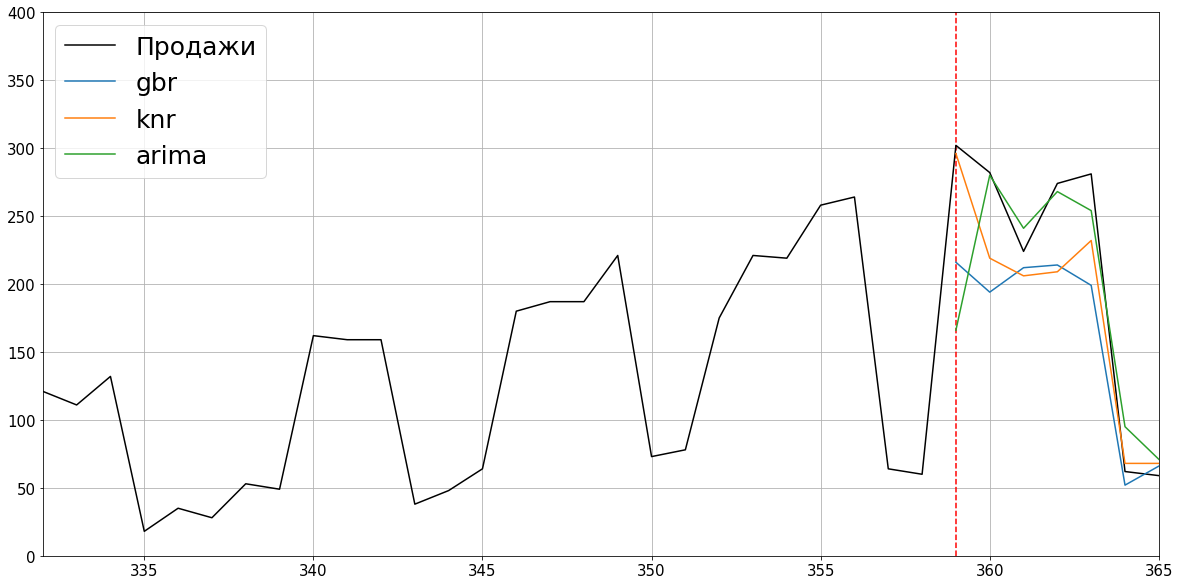

In [32]:
#testPredict_xgbr = np.empty_like(df.Sales)
#testPredict_xgbr[:] = 0
#testPredict_xgbr[M:N] = xgbr.predict(X_test)

#testPredict_mlpr = np.empty_like(df.Sales)
#testPredict_mlpr[:] = 0
#testPredict_mlpr[M:N] = mlpr.predict(X_test)

testPredict_gbr = np.empty_like(df_1.Продажи)
testPredict_gbr[:] = 0
testPredict_gbr[M:N] = gbr.predict(X_test)

testPredict_knr = np.empty_like(df_1.Продажи)
testPredict_knr[:] = 0
testPredict_knr[M:N] = knr.predict(X_test)

testPredict_arima = np.empty_like(df_1.Продажи)
testPredict_arima[:] = 0
testPredict_arima[M:N] = arima_predictions

print('model\t\t MAE \t MSE')
#print('xgbr:\t\t', round(mean_absolute_error(testPredict_xgbr[-test:], df_1.Продажи[-test:]), 2), '\t', round(mean_squared_error(testPredict_xgbr[-test:], df_1.Продажи[-test:]),2))
#print('mlpr:\t\t', round(mean_absolute_error(testPredict_mlpr[-test:], df_1.Продажи[-test:]), 2), '\t', round(mean_squared_error(testPredict_mlpr[-test:], df_1.Продажи[-test:]),2))
print('gbr:\t\t', round(mean_absolute_error(testPredict_gbr[-test:], df_1.Продажи[-test:]), 2), '\t', round(mean_squared_error(testPredict_gbr[-test:], df_1.Продажи[-test:]),2))
print('knr:\t\t', round(mean_absolute_error(testPredict_knr[-test:], df_1.Продажи[-test:]), 2), '\t', round(mean_squared_error(testPredict_knr[-test:], df_1.Продажи[-test:]),2))
print('arima:\t\t', round(mean_absolute_error(testPredict_arima[-test:], df_1.Продажи[-test:]), 2), '\t', round(mean_squared_error(testPredict_arima[-test:], df_1.Продажи[-test:]),2))

plt.axvline(x=len(df_1)-test, c = 'red', linestyle = '--')
plt.plot(df_1.Продажи[M-100:N], c = 'black', label='Продажи')
#plt.plot(pd.DataFrame(testPredict_xgbr)[-test:], label='xgbr')
#plt.plot(pd.DataFrame(testPredict_mlpr)[-test:], label='mlpr')
plt.plot(pd.DataFrame(testPredict_gbr)[-test:], label='gbr')
plt.plot(pd.DataFrame(testPredict_knr)[-test:], label='knr')
plt.plot(pd.DataFrame(testPredict_arima)[-test:], label='arima')
plt.grid()
plt.xlim(M-test-20, N-1)
plt.ylim(0, 400)
plt.legend(loc='upper left', prop={'size': 25})
plt.show()